# Auckland House Prices Analysis

Executive Summary
The dataset is based in Auckland the objective to create a linear regression to prdict house price base on features in the data, which was provided in the MSA phase 1 data-science pathway.
It contains all a variety of information regarding houses in Auckland along with price evaluation and land and bedroom information as well as longitude and latitude information. However, some information related to the population for housing was missing. So API call to a 2018 census dataset was conducted using longitude, latitude through a vector query and SA1 from the initial dataset for each house and a new column was inserted into the dataset. Additionally, the depression index was also added to the primary dataset using Otago researched-based dataset on house depression in Auckland.Finally, some data clean was completed; Nan values were replaced with estimates. Some of the data in the housing data set contained categorical data which required transformations for plotting visualisations. These were suburbs and address.

The analysis is based on 981 observations for each of the 17 variables. A correlation matrix was used initially to see if any of the 17 variables were related price CV (estimate of the house price)  if they had a strong relationship.Before this, descriptive statistics was used initially to determine the spread of each variable. Additionally, outliers were removed with an interquartile range metric using land Area. Three correlated values were found; these were Bedrooms, Bathrooms, NZDep2018.Finally, a linear regression model was then fitted to predict CV base on these inputs.

In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sys
import pandas as pd
import requests
import time 
%matplotlib inline 

In [311]:
#different suburbs effect prices bedrrom size of house land etc  givin a price ,surburbs, rooms predict the price
# using regression good anaylsis techiques using to determine 
house_prices = pd.read_csv('DatasetforAssignment.csv')
#remove data types i.e  object to float 
house_prices.head()


,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs
0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,Manurewa
1,5,3.0,"8 Corsica Way Karaka, Auckland",564,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,Karaka
2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,Karaka
3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,Onehunga
4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,Clover Park


In [313]:
#remove convert colcumn to float and remove chars in text
house_prices['Land area'] = house_prices['Land area'].str.extract('(\d+)').astype(float)

In [315]:
#load in the depresisation scores 
dep_indexs = pd.read_excel('otago730395.xlsx')
dep_indexs.head()

,SA12018_code,NZDep2018,NZDep2018_Score,URPopnSA1_2018,SA22018_code,SA22018_name
0,7000000,10.0,1245.0,141,100100,North Cape
1,7000001,10.0,1245.0,114,100100,North Cape
2,7000002,NaN,NaN,0,100300,Inlets Far North District
3,7000003,10.0,1207.0,225,100100,North Cape
4,7000004,9.0,1093.0,138,100100,North Cape


In [317]:
#now we need to get make the requests from the API for population at Latitude and Longitude
def get_pop_at_lat_long(long,lat):
    url = 'https://koordinates.com/services/query/v1/vector.json'
    #from nz cenius data
    layer_id = 104612
    params = {
        'key':'772a6ce37abd44a7a65fb8af6ad6ac28',
        'layer' : layer_id,
        'x':long,
        'y':lat,
        'format':'json'
    }
    response = requests.get(url,params = params)
    if(response.status_code != 200):
        return response.status_code
    return response.json()

# handles the reponse from the function above extracts relvatant information
def parse_response(input_json_response,sa1):
    layer_id = '104612'
    cencius_data = input_json_response['vectorQuery']['layers'][layer_id]['features']
    for item in cencius_data:
        res_SA1 = item['properties']['SA12018_V1_00']
        if (int(res_SA1) == int(sa1) ):
            C18_CURPop = item['properties']['C18_CURPop']
            return {"SA12018_V1_00":int(sa1),"C18_CURPop":int(C18_CURPop)}        
    return {"SA12018_V1_00":int(sa1),"C18_CURPop":None}
        
# used to get population value 
def extract_population(long,lat,sa1):
    api_data_response = get_pop_at_lat_long(long,lat)
    population_value =  parse_response(api_data_response,sa1)
    return population_value["C18_CURPop"]

#extract the dep index from one dataframe ouput it SA1 
def extract_depreciation(df_dep,sa1):
    # get row where sa1 has the same value 
    row = df_dep.loc[df_dep['SA12018_code'] == sa1]
    return float(row['NZDep2018'])



In [319]:
sample_house_prices['C18_CURPop'] = sample_house_prices.apply(lambda row : extract_population(row['Longitude'],row['Latitude'],row['SA1']),axis = 1)
sample_house_prices.head()

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,C18_CURPop,NZDep2018
0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714.0,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,Manurewa,174,6.0
1,5,3.0,"8 Corsica Way Karaka, Auckland",564.0,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,Karaka,129,1.0
2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626.0,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,Karaka,129,1.0
3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65.0,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,Onehunga,120,2.0
4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601.0,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,Clover Park,231,9.0


In [321]:
#adding the depreciation  colcumn
sample_house_prices['NZDep2018'] = sample_house_prices.apply(lambda row : extract_depreciation(dep_indexs,row['SA1']),axis = 1)
sample_house_prices.head()

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,C18_CURPop,NZDep2018
0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714.0,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,Manurewa,174,6.0
1,5,3.0,"8 Corsica Way Karaka, Auckland",564.0,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,Karaka,129,1.0
2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626.0,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,Karaka,129,1.0
3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65.0,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,Onehunga,120,2.0
4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601.0,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,Clover Park,231,9.0


Adding the two extra columns for houses price dataset

In [323]:
house_prices['C18_CURPop'] = house_prices.apply(lambda row : extract_population(row['Longitude'],row['Latitude'],row['SA1']),axis = 1)

In [339]:
house_prices['NZDep2018'] = house_prices.apply(lambda row : extract_depreciation(dep_indexs,row['SA1']),axis = 1)

In [327]:
house_prices.head()

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,C18_CURPop,NZDep2018
0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714.0,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,Manurewa,174,6.0
1,5,3.0,"8 Corsica Way Karaka, Auckland",564.0,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,Karaka,129,1.0
2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626.0,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,Karaka,129,1.0
3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65.0,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,Onehunga,120,2.0
4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601.0,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,Clover Park,231,9.0


The above data frame imported contains a variety of information for houses in Auckland. An investigation is being conducted to determine if we can estimate houses prices based on information related house features. To determine the relevant features, we are going to perform some visualisations with the data frame to look for patterns.

In [328]:
# check if any row has null value NEED to check for outliers 
pd.isnull(house_prices[:]).any(axis=1)
nan_stuff = house_prices[house_prices.isnull().any(axis=1)]
print(nan_stuff)

     Bedrooms  Bathrooms                                            Address  \
309         4        NaN                  14 Hea Road Hobsonville, Auckland   
311         4        NaN                  16 Hea Road Hobsonville, Auckland   
568         1        1.0  14 Te Rangitawhiri Road Great Barrier Island, ...   

     Land area       CV   Latitude   Longitude      SA1  0-19 years  \
309      214.0  1250000 -36.798371  174.647430  7002267          60   
311      245.0  1100000 -36.798371  174.647430  7002267          60   
568     2141.0   740000 -36.197282  175.416921  7001131          27   

     20-29 years  30-39 years  40-49 years  50-59 years  60+ years  \
309           66           60           24           24         18   
311           66           60           24           24         18   
568            6            6           18           39         60   

         Suburbs  C18_CURPop  NZDep2018  
309  Hobsonville         252        2.0  
311  Hobsonville         252     

In [329]:
#from this we found NaN values in the dataset two bathroom entrys and Suburb entry 
subs = house_prices[house_prices['Suburbs'] == 'Hobsonville']
print(subs)

     Bedrooms  Bathrooms                                  Address  Land area  \
223         4        2.0  10 Eyton Kay Road Hobsonville, Auckland      161.0   
309         4        NaN        14 Hea Road Hobsonville, Auckland      214.0   
310         4        2.0        12 Hea Road Hobsonville, Auckland      191.0   
311         4        NaN        16 Hea Road Hobsonville, Auckland      245.0   
449         5        4.0     10 Mantis Lane Hobsonville, Auckland      336.0   
460         4        2.0   12 Williams Road Hobsonville, Auckland      450.0   
666         3        2.0     17 Kanuka Road Hobsonville, Auckland      259.0   

          CV   Latitude   Longitude      SA1  0-19 years  20-29 years  \
223   860000 -36.795951  174.655930  7002301          51           36   
309  1250000 -36.798371  174.647430  7002267          60           66   
310   530000 -36.798371  174.647430  7002267          60           66   
311  1100000 -36.798371  174.647430  7002267          60           

In [330]:
print(house_prices.dtypes)

Bedrooms         int64
Bathrooms      float64
Address         object
Land area      float64
CV               int64
Latitude       float64
Longitude      float64
SA1              int64
0-19 years       int64
20-29 years      int64
30-39 years      int64
40-49 years      int64
50-59 years      int64
60+ years        int64
Suburbs         object
C18_CURPop       int64
NZDep2018      float64
dtype: object


In [331]:
speard_attributes = house_prices.describe()

In [340]:
subs_unclean = house_prices[house_prices['Suburbs'] == 'Hobsonville']
subs = subs_unclean.dropna()

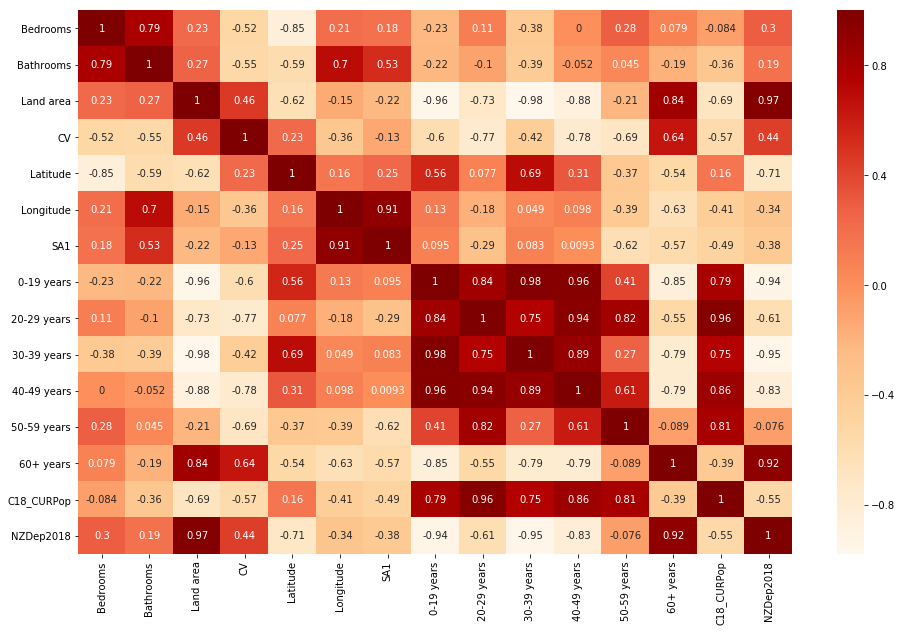

In [333]:
#using the subs we will try to predict the nan value for bathrooms based on similar houses in the suburbs  consider values of 0.5 and higher 
ax, fig = plt.subplots(figsize= (16,10))
correlation_matrix = subs.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="OrRd")
plt.show()

From the correlation matrix above, we found some features related to CV they now used later for predicting them. These are a houses Bedrooms, Bathrooms and house depression index.

In [334]:
#creating a linear regression model for Bathrooms
feature_names = ['Bedrooms','SA1','CV','Latitude','Longitude']
#contains the rows we need to predict to fill in.
input_for_predicting = subs_unclean[subs_unclean['Bathrooms'].isna()]
input_for_predicting

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,C18_CURPop,NZDep2018
309,4,NaN,"14 Hea Road Hobsonville, Auckland",214.0,1250000,-36.798371,174.64743,7002267,60,66,60,24,24,18,Hobsonville,252,2.0
311,4,NaN,"16 Hea Road Hobsonville, Auckland",245.0,1100000,-36.798371,174.64743,7002267,60,66,60,24,24,18,Hobsonville,252,2.0


In [335]:
#Machine learning model 
#split into trainning set and test set for after trainning 

from sklearn.model_selection import train_test_split
y = subs[['Bathrooms']]
x = subs[feature_names]
print(x)
print(y)

     Bedrooms      SA1       CV   Latitude   Longitude
223         4  7002301   860000 -36.795951  174.655930
310         4  7002267   530000 -36.798371  174.647430
449         5  7002304   545000 -36.801329  174.666149
460         4  7002271  1125000 -36.800550  174.645182
666         3  7002295   920000 -36.793782  174.660944
     Bathrooms
223        2.0
310        2.0
449        4.0
460        2.0
666        2.0


In [336]:
# we have the input and output data ready now we can go about finding linear regression model to predict bathroom subur
#import linear regression model for cont data 
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [337]:
model.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [338]:
#determine model coefficents 
model.coef_
 

array([[ 8.06711279e-01, -3.49804349e-02,  5.87961799e-07,
        -3.46078799e+01,  1.26950090e+02]])

In [341]:
# from nan row 
x_input = input_for_predicting[feature_names]
predicted_bathrooms = model.predict(x_input)

In [342]:
predicted_bathrooms = np.round(predicted_bathrooms) # round the float value 

In [343]:
house_prices.loc[house_prices['Bathrooms'].isnull(),'Bathrooms'] = predicted_bathrooms
house_prices[house_prices['Suburbs'] == 'Hobsonville']

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,C18_CURPop,NZDep2018
223,4,2.0,"10 Eyton Kay Road Hobsonville, Auckland",161.0,860000,-36.795951,174.655930,7002301,51,36,57,18,6,12,Hobsonville,174,1.0
309,4,2.0,"14 Hea Road Hobsonville, Auckland",214.0,1250000,-36.798371,174.647430,7002267,60,66,60,24,24,18,Hobsonville,252,2.0
310,4,2.0,"12 Hea Road Hobsonville, Auckland",191.0,530000,-36.798371,174.647430,7002267,60,66,60,24,24,18,Hobsonville,252,2.0
311,4,2.0,"16 Hea Road Hobsonville, Auckland",245.0,1100000,-36.798371,174.647430,7002267,60,66,60,24,24,18,Hobsonville,252,2.0
449,5,4.0,"10 Mantis Lane Hobsonville, Auckland",336.0,545000,-36.801329,174.666149,7002304,33,30,24,15,12,18,Hobsonville,135,4.0
460,4,2.0,"12 Williams Road Hobsonville, Auckland",450.0,1125000,-36.800550,174.645182,7002271,12,12,9,6,9,75,Hobsonville,129,7.0
666,3,2.0,"17 Kanuka Road Hobsonville, Auckland",259.0,920000,-36.793782,174.660944,7002295,45,24,48,15,6,12,Hobsonville,147,2.0


Once again we check if null value exists 

In [344]:
last_nan = house_prices[house_prices.isnull().any(axis=1)]
last_nan

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,C18_CURPop,NZDep2018
568,1,1.0,"14 Te Rangitawhiri Road Great Barrier Island, ...",2141.0,740000,-36.197282,175.416921,7001131,27,6,6,18,39,60,NaN,156,9.0


it's only one entry so just check google maps and checked if in the subset of Surburbs 

In [345]:
# Great Barrier Island is the column so we just need to replace that entry.Used a google search because it was only one entry and was catgolical 
house_prices.loc[house_prices['Suburbs'].isnull(),'Suburbs'] = 'Great Barrier Island (Aotea Island)'

In [346]:
#complete with the nan completely clean from the dataset 
house_prices.isnull().values.any()

False

Now I will going to look at the spread of each column 

In [347]:
def Outlier_range(q1,q3):
    IQR = q3 - q1
    lower = q1 - 1.5 * IQR
    upper = q3 + 1.5 * IQR
    return [lower,upper]


In [348]:
#encoding the suburbs as dictonary so that visulation libary's can plot the surburbs column 
labels = house_prices['Suburbs'].astype('category').cat.categories.tolist()
replace_map_comp = {'Suburbs' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
replace_map_comp

{'Suburbs': {'Albany Heights': 1,
  'Alfriston': 2,
  'Army Bay': 3,
  'Auckland Central': 4,
  'Avondale': 5,
  'Beach Haven': 6,
  'Beachlands': 7,
  'Belmont': 8,
  'Birkdale': 9,
  'Birkenhead': 10,
  'Blockhouse Bay': 11,
  'Bombay': 12,
  'Botany Downs': 13,
  'Browns Bay': 14,
  'Buckland': 15,
  'Bucklands Beach': 16,
  'Burswood': 17,
  'Campbells Bay': 18,
  'Chatswood': 19,
  'Clarks Beach': 20,
  'Clendon Park': 21,
  'Clover Park': 22,
  'Cockle Bay': 23,
  'Conifer Grove': 24,
  'Dairy Flat': 25,
  'Dannemora': 26,
  'Drury': 27,
  'East Tamaki': 28,
  'East Tamaki Heights': 29,
  'Eastern Beach': 30,
  'Eden Terrace': 31,
  'Ellerslie': 32,
  'Epsom': 33,
  'Farm Cove': 34,
  'Favona': 35,
  'Flat Bush': 36,
  'Forrest Hill': 37,
  'Freemans Bay': 38,
  'Glen Eden': 39,
  'Glen Innes': 40,
  'Glendene': 41,
  'Glendowie': 42,
  'Glenfield': 43,
  'Golflands': 44,
  'Goodwood Heights': 45,
  'Great Barrier Island (Aotea Island)': 46,
  'Green Bay': 47,
  'Greenlane': 48,


In [349]:
#making a copy to modify the suburbs data directly 
house_prices_replace = house_prices.copy()

In [350]:
#replace the numeric values in dataframe for suburbs 
house_prices_replace.replace(replace_map_comp, inplace=True)


In [351]:
house_prices_replace.dtypes

Bedrooms         int64
Bathrooms      float64
Address         object
Land area      float64
CV               int64
Latitude       float64
Longitude      float64
SA1              int64
0-19 years       int64
20-29 years      int64
30-39 years      int64
40-49 years      int64
50-59 years      int64
60+ years        int64
Suburbs          int64
C18_CURPop       int64
NZDep2018      float64
dtype: object

In [352]:
#droping the address column because suburbs can act as more generic input for our model 
house_prices_replace.drop(['Address'],axis=1).head()

,Bedrooms,Bathrooms,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,C18_CURPop,NZDep2018
0,5,3.0,714.0,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,79,174,6.0
1,5,3.0,564.0,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,65,129,1.0
2,6,4.0,626.0,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,65,129,1.0
3,2,1.0,65.0,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,102,120,2.0
4,3,1.0,601.0,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,22,231,9.0


In [353]:
stats_house_prices_replace= house_prices_replace.describe()
stats_house_prices_replace
house_prices_replace.shape
house_prices_replace.describe()

,Bedrooms,Bathrooms,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,C18_CURPop,NZDep2018
count,1051.000000,1051.000000,1051.000000,1.051000e+03,1051.000000,1051.000000,1.051000e+03,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000
mean,3.777355,2.073264,856.989534,1.387521e+06,-36.893715,174.799325,7.006319e+06,47.549001,28.963844,27.042816,24.125595,22.615604,29.360609,94.834443,179.914367,5.063749
std,1.169412,0.992044,1588.156219,1.182939e+06,0.130100,0.119538,2.591262e+03,24.692205,21.037441,17.975408,10.942770,10.210578,21.805031,50.446475,71.059280,2.913471
min,1.000000,1.000000,40.000000,2.700000e+05,-37.265021,174.317078,7.001130e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000
25%,3.000000,1.000000,321.000000,7.800000e+05,-36.950565,174.720779,7.004416e+06,33.000000,15.000000,15.000000,18.000000,15.000000,18.000000,54.000000,138.000000,2.000000
50%,4.000000,2.000000,571.000000,1.080000e+06,-36.893132,174.798575,7.006325e+06,45.000000,24.000000,24.000000,24.000000,21.000000,27.000000,93.000000,174.000000,5.000000
75%,4.000000,3.000000,825.000000,1.600000e+06,-36.855789,174.880944,7.008384e+06,57.000000,36.000000,33.000000,30.000000,27.000000,36.000000,139.000000,210.000000,8.000000
max,17.000000,8.000000,22240.000000,1.800000e+07,-36.177655,175.492424,7.011028e+06,201.000000,270.000000,177.000000,114.000000,90.000000,483.000000,189.000000,789.000000,10.000000


Initial Data Exploration
The initial exploration of the data began with the collecting of current population value through an API then merging the existing data frame and combining with depreciation index of houses. Then NAN values in the dataset were replaced with estimates. Finally along with converting a suburbs column into category variable. The descriptive statistics summary was used to calculate outliers. This then reduced the number of rows to 1051—shown bellow with an interquartile estimate.

In [354]:
#removing outliers from Land Area CV these should also remove the houses rows larger amounts bedrooms 
q1 = stats_house_prices_replace['Land area'].loc['25%']
q3 = stats_house_prices_replace['Land area'].loc['75%']
outrang = Outlier_range(q1,q3)
print(outrang)
house_prices_replace = house_prices_replace[house_prices_replace['Land area'] <  outrang[1]] # check if outside the outer range 

[-435.0, 1581.0]


In [355]:
house_prices_replace.describe()

,Bedrooms,Bathrooms,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,C18_CURPop,NZDep2018
count,981.000000,981.000000,981.000000,9.810000e+02,981.000000,981.000000,9.810000e+02,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000
mean,3.733945,2.047910,560.669725,1.326148e+06,-36.896886,174.797593,7.006361e+06,47.828746,29.483180,27.623853,24.024465,22.244648,28.993884,94.107034,180.458716,5.160041
std,1.053449,0.955515,334.873663,1.003560e+06,0.120351,0.107924,2.538859e+03,25.147103,21.451249,18.260256,11.017677,10.016175,22.196662,50.093645,72.527219,2.897549
min,1.000000,1.000000,40.000000,2.700000e+05,-37.265021,174.433162,7.001158e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,1.000000
25%,3.000000,1.000000,304.000000,7.700000e+05,-36.949429,174.723850,7.004537e+06,33.000000,18.000000,15.000000,18.000000,15.000000,18.000000,54.000000,138.000000,3.000000
50%,4.000000,2.000000,536.000000,1.050000e+06,-36.894835,174.797892,7.006334e+06,45.000000,27.000000,24.000000,24.000000,21.000000,27.000000,92.000000,174.000000,5.000000
75%,4.000000,3.000000,763.000000,1.550000e+06,-36.857091,174.879070,7.008379e+06,57.000000,36.000000,36.000000,30.000000,27.000000,36.000000,139.000000,210.000000,8.000000
max,8.000000,7.000000,1573.000000,1.800000e+07,-36.298627,175.187565,7.011028e+06,201.000000,270.000000,177.000000,114.000000,90.000000,483.000000,189.000000,789.000000,10.000000


In [356]:
house_prices_replace.shape
# removed some of rows which outliers 

(981, 17)

Their exists a continuous version of NZDEP index otago datatset so adding it to house_prices datatset see if releationship could be found.

In [358]:
def continuous_extract_depreciation(df_dep,sa1):
    # get row where sa1 has the same value 
    row = df_dep.loc[df_dep['SA12018_code'] == sa1]
    return float(row['NZDep2018_Score'])

In [359]:
house_prices_replace['NZDep2018_Score'] = house_prices_replace.apply(lambda row : continuous_extract_depreciation(dep_indexs,row['SA1']),axis = 1)

Correlation and Relationships
Numeric Relationships
The correlation between the numeric columns was calculated and observed in the below
correlation plot. (The right colour bar indicated the correlation values. For example, the dark red means
correlation value is 1, and pale yellow means correlation value is negative 1.)
The graph shows that Bedrooms, Bathrooms and NZDep2018 correlate
with CV.

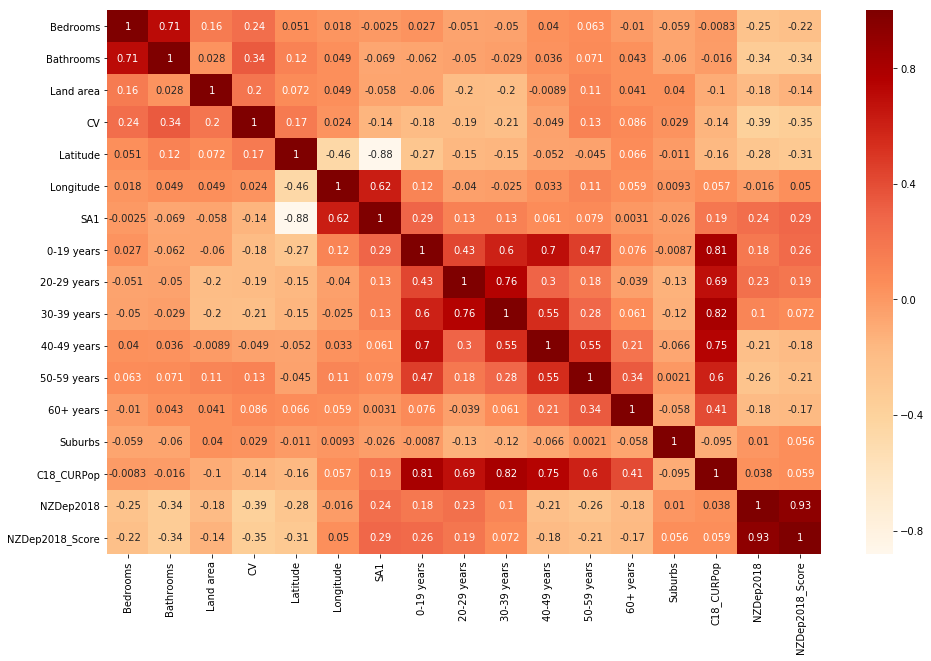

In [360]:
# check the collrection matrix now  added the continous depression 
ax, fig = plt.subplots(figsize= (16,10))
correlation_matrix = house_prices_replace.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="OrRd")
plt.show()

Bellow using the correlation matrix for CV visulations for, releated variables were created and analyzed. 

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


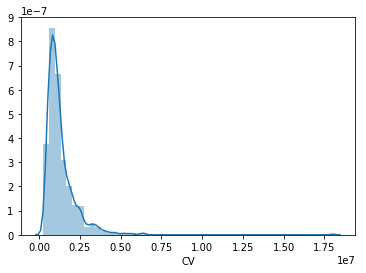

In [361]:
sns.distplot(house_prices_replace['CV'])

Price of the house is right-skewed, so log transformation was applied resulting in more normally distributed data 

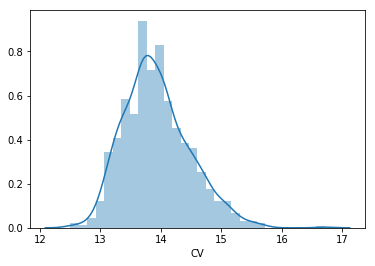

In [362]:
sns.distplot(np.log(house_prices_replace['CV']))

In [363]:
# now the price is in log form 
house_prices_replace['CV'] = house_prices_replace['CV'].apply(np.log)

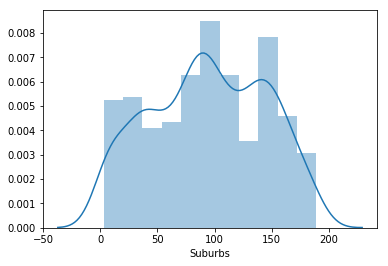

In [364]:
sns.distplot(house_prices_replace['Suburbs'])

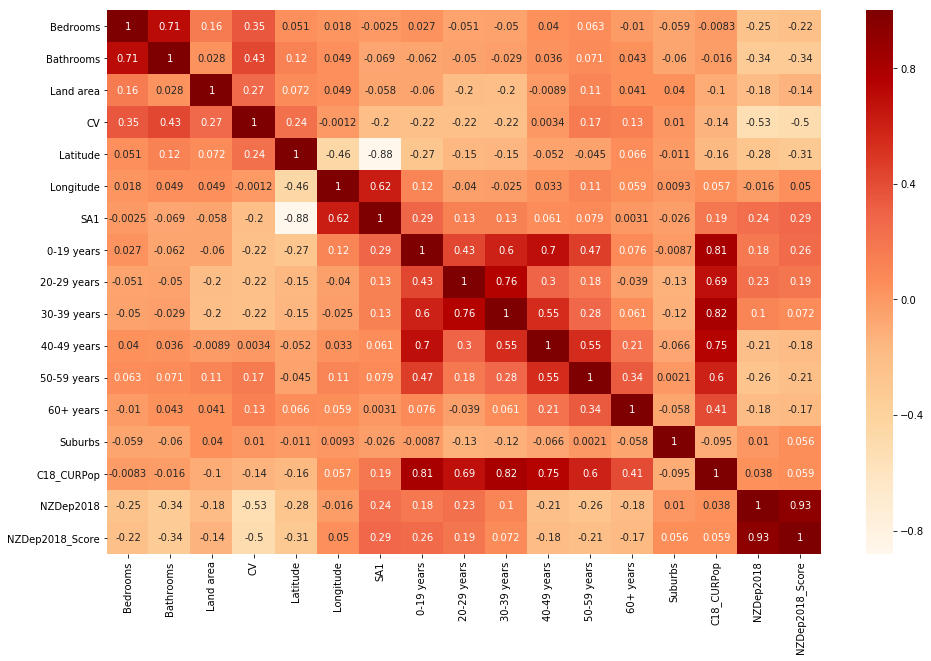

In [365]:
# check the collrection matrix now  added the continous depression 
ax, fig = plt.subplots(figsize= (16,10))
correlation_matrix = house_prices_replace.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="OrRd")
plt.show()

The above correlation matrix indicates CV is related negatively with NZDep index value and positively associated with Bathroom area, hinting at the higher number of bathrooms in the house, the higher it estimated cost. So we will now develop the linear regression model for CV based on NZDep index bedrooms, Bathrooms. Note that the output of CV is log form, so when using the linear model for predications, it required to exp the output to get house price.

Analysis

In this analysis, Linear regression was tested.
These algorithms were trained with 40% of the data. Testing the model with the remaining 60% of
the data yielded the following results:

In [366]:
#define the inputs x contains NZDep2018 data along with Bathroom data 
#define y out data being log of CV 
x =  house_prices_replace[['Bedrooms','Bathrooms','NZDep2018']]
y =  house_prices_replace['CV']
#dealing with 981 data points per column
len(x)



981

In [367]:
#splicting the data into training and predicting batchs 
train_x , test_x, train_y, test_y = train_test_split(x,y,test_size = 0.4, random_state=42) 

In [368]:
#define a new regression linear model
model_CV = LinearRegression()


In [369]:
model_CV.fit(train_x,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [370]:
#determine model coefficents 
model_CV.coef_

array([ 0.02176466,  0.15031556, -0.08151677])

In [372]:
predicted = model_CV.predict(test_x)

Analysis
The decision for the model chosen, process and results

Conclusion 
This analysis has shown that the (house price) in log scale prediction can not be confidently predicted from it's a number of Bedrooms, Bathrooms and property depreciation index. The accuracy rate is 33% which bellow 50 % and scatter plot has revealed house price doesn't follow a linear trend there might need to be some additional work need with cleaning the input into the model or transformations need on the inputs.

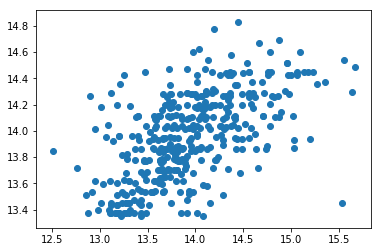

In [373]:
plt.scatter(test_y,predicted)

In [374]:
model_CV.score(test_x,test_y)

0.33913597501995824

The model above give a score of 0.34. which similar to corrlated values in correlation matrix.However from looking at the scatter plot it looks like data is very sparce
it indicates it more cleaning would need to be done with input into the model.